# SD701 PROJECT DATA MINING :  Usage des hotspots de wi-fi publiques à Paris
## FRIKHA Mohamed | KOUADIO Aurélien

# INTRODUCTION:

Le projet 'Usage des hotspots de wi-fi publics à Paris' comporte comme un jeu de données d'environ deux millions lignes sur les utilisateurs des bornes Wifi publics à Paris ( les début/fin connexion, la quantité de data, localisation, code postal etc...)
Le but de ce projet de faire une fouille sur les données de ces utililsateurs autrement dit avoir une idée sur leurs comportements, leurs appareils, leurs durées de connexion et quantité de data utilisée etc...
Nous essaierons de repondre à des questions comme : (est ce que le COVID-19 a changer le comportement des utilsateurs ?, est ce qu'on a besoin d'installer des nouvelles hotspots Wifi? est ce que ces hotspots sont utiles?

Lien des données : https://opendata.paris.fr/explore/dataset/paris-wi-fi-utilisation-des-hotspots-paris-wi-fi/information/?disjunctive.incomingzonelabel&disjunctive.incomingnetworklabel&disjunctive.device_portal_format&disjunctive.device_constructor_name&disjunctive.device_operating_system_name_version&disjunctive.device_browser_name_version&disjunctive.userlanguage

## I . IMPORTATION

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
from glob import glob
import seaborn as sns
import plotly as px
pd.options.mode.chained_assignment = None  # default='warn'
import folium
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from folium import plugins
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, shape

## II. PREPARATION DES DONNES 

Fichier initial est un CSV de gros volume avec 1.6 millions de lignes. L'idée de cette étape c'est de transformer le fichier CSV en fichier pickle afin de pouvoir manipuler et travailler sur un fichier de taille réduite en conservant toutes les donneés.On créera ensuite une fonction de nettoyage des données qui nous aidera à supprimer/renommer/modifier les lignes et les colonnes non utiles et conservera les observations utiles pour notre projet.

In [2]:
# Telechargement des données => On a commenté à cause du temps de chargement

# data =pd.read_csv('paris-wi-fi-utilisation-des-hotspots-paris-wi-fi.csv',sep =';',low_memory=False)
# data.to_pickle('data1.pkl')
# data.head()

In [3]:
# Recall pickle
data=pd.read_pickle('data1.pkl')

In [4]:
# Nettoyage
#Fonction de nettoyage (après avoir observé les data brutes)
def preparation_données(data):
    data['Type d\'appareil'].replace(to_replace="Tablet",value="Tablette", inplace=True)
    data['Type d\'appareil'].replace(to_replace="Computer",value="Ordinateur", inplace=True)
    data['Constructeur appareil'].replace(to_replace="other",value="autre", inplace=True)
    data['Constructeur appareil'].replace(to_replace="ARCHOS",value="autre", inplace=True)
    data['Constructeur appareil'].replace(to_replace="Sony",value="autre", inplace=True)
    data['Constructeur appareil'].replace(to_replace="RIM",value="autre", inplace=True)
    data["Date heure fin"]=data[data.columns[1]].apply(lambda x: x.split('T')[1].split('+')[0])
    data["Date heure début"]=data[data.columns[1]].apply(lambda x: x.split('T')[0])
    data=data.rename(columns={"Date heure fin":"Heure début","Date heure début":"Date début"})
    data = data.drop(data.columns[[4,5,10,11,13,15,16,18,21,22,24]], axis=1)
    data.set_index('Code Site', drop=True, inplace=True)
    s = data['Version système exploitation'].astype(str)
    mapping1 = {val: 'Android' for val in s.loc[s.str.contains('And')]}
    mapping2 = {val: 'Mac' for val in s.loc[s.str.contains('Mac')]}
    mapping3 = {val:  'Windows' for val in s.loc[s.str.contains('Wind')]}
    mapping4 = {val:  'iOS' for val in s.loc[s.str.contains('iOS')]}
    mapping5 = {val:'Playstation Vita' for val in s.loc[s.str.contains('Playstation')]}
    mapping6 = {'inconnu':'Autre'}
    mapping7 = {val:  'Windows Phone' for val in s.loc[s.str.contains('Phone')]}
    mapping1.update(mapping2)
    mapping1.update(mapping3)
    mapping1.update(mapping4)
    mapping1.update(mapping5)
    mapping1.update(mapping6)
    mapping1.update(mapping7)
    data['Version système exploitation']= data['Version système exploitation'].map(mapping1)
    data['Code postal'] = data['Code postal'].str.replace('MAISON VICTOR HUGO','75004').replace('MUSEE CARNAVALET','75003').replace("MUSEE DE LA LIBERATION",'75014')
    data = data.dropna(subset=['Code postal'])
    data.drop(data.loc[data['Code postal']=='92100'].index, inplace=True)
    data['Arrondissement'] = data['Code postal'].astype('int').mod(7500)
    data.head()
    data = data.dropna(how = 'any')
    return data

In [5]:
# Lancement de la fonction de nettoyage 
df = preparation_données(data)
df.head(5)

Date début Heure début  Temps de session en secondes Code postal  \
Code Site                                                                     
PW0123     2019-09-01    01:57:00                           227       75004   
PW0175     2019-09-01    10:41:00                           422       75016   
PW0165     2019-09-01    11:21:00                           498       75007   
PW0170-1   2019-09-01    11:21:00                           705       75018   
PW0176     2019-09-01    12:07:00                           241       75009   

          Type d'appareil Constructeur appareil Version système exploitation  \
Code Site                                                                      
PW0123             Mobile                 autre                        Autre   
PW0175             Mobile                 autre                      Android   
PW0165             Mobile                 Apple                          iOS   
PW0170-1           Mobile                 autre                      Android   
PW0176             Mobile                 Apple                          iOS   

           Donnée entrante (MégaOctet)  Donnée sortante (MégaOctet)  \
Code Site                                                             
PW0123                        7.345041                     0.620479   
PW0175                        6.281727                     2.515600   
PW0165                        3.613858                    36.854736   
PW0170-1                     12.846315                     1.298436   
PW0176                        7.102993                    11.631099   

          Langue utilisateur                 geo_point_2d  Etat du site  \
Code Site                                                                 
PW0123              Français  48.8563193139,2.35175507673  Opérationnel   
PW0175               Anglais  48.8609372147,2.28934994437  Opérationnel   
PW0165               Anglais  48.8569794103,2.29333906348  Opérationnel   
PW0170-1               Arabe  48.8858336546,2.36504782956  Opérationnel   
PW0176              Français  48.8765956695,2.33179827521  Opérationnel   

           Nombre de bornes  Arrondissement  
Code Site                                    
PW0123                  1.0               4  
PW0175                  1.0              16  
PW0165                  1.0               7  
PW0170-1                2.0              18  
PW0176                  1.0               9

**Vérifier les données, des lignes Nan? et les types etc..**

In [6]:
# pour savoir si on des valeurs null aprés le netoyage
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Date début, Heure début, Temps de session en secondes, Code postal, Type d'appareil, Constructeur appareil, Version système exploitation, Donnée entrante (MégaOctet), Donnée sortante (MégaOctet), Langue utilisateur, geo_point_2d, Etat du site, Nombre de bornes, Arrondissement]
Index: []

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456905 entries, PW0123 to PW0224
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Date début                    1456905 non-null  object 
 1   Heure début                   1456905 non-null  object 
 2   Temps de session en secondes  1456905 non-null  int64  
 3   Code postal                   1456905 non-null  object 
 4   Type d'appareil               1456905 non-null  object 
 5   Constructeur appareil         1456905 non-null  object 
 6   Version système exploitation  1456905 non-null  object 
 7   Donnée entrante (MégaOctet)   1456905 non-null  float64
 8   Donnée sortante (MégaOctet)   1456905 non-null  float64
 9   Langue utilisateur            1456905 non-null  object 
 10  geo_point_2d                  1456905 non-null  object 
 11  Etat du site                  1456905 non-null  object 
 12  Nombre de bornes             

## III. Analyse des données :

###  Etude sur les langues d'utilisateur:

Langue utilisateur
Indonésien                  128
Thaïlandais                 412
Chinois traditionnel        581
Coréen                     3029
Polonais                   3283
Japonais                   3817
Néerlandais                4186
Arabe                      8310
Chinois simplifié         11053
Italien                   13543
Portugais                 15055
Allemand                  18091
Russe                     26043
Espagnol                  33612
Anglais                  214007
Français                1101755
dtype: int64

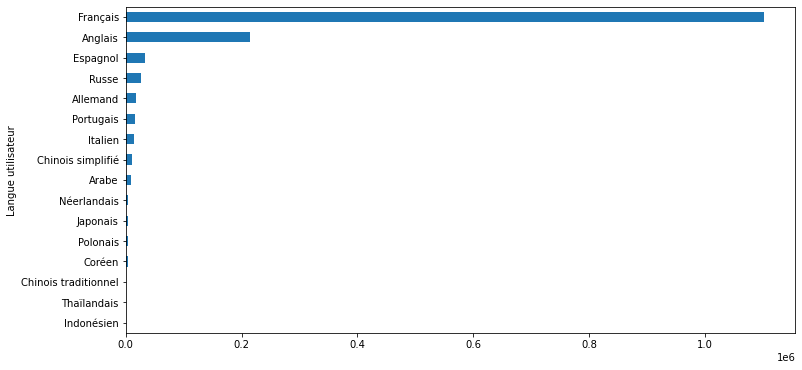

In [8]:
dt_language = df.groupby('Langue utilisateur').size().sort_values()
dt_language.plot.barh(figsize = (12,6))
dt_language

On constate que la langue la plus utilisée parmi les 1.7 millions d'utilisateurs est le français avec 1.1 millions, ce qui est tout à fait normal parce que le dataset est extraite d'utilisateurs Parisiens. Il faut également noter que la langue française est utilisée souvent par d'autres nationalités comme une deuxième langue. Afin de mieux apprécier les langues des utilisateurs on va éliminer la langue française dans le prochain chemin et comparer entres les autre langues.

In [9]:
dt_language = pd.DataFrame(dt_language)
dt_language = dt_language.reset_index()
dt_language.columns = ['Langue utilisateur', 'Nombre']
indexNames = dt_language[dt_language['Langue utilisateur'] == 'Français' ].index
# Delete these row indexes from dataFrame
dt_language.drop(indexNames , inplace=True)
dt_language.set_index('Langue utilisateur',inplace = True)

Nombre
Langue utilisateur          
Indonésien               128
Thaïlandais              412
Chinois traditionnel     581
Coréen                  3029
Polonais                3283
Japonais                3817
Néerlandais             4186
Arabe                   8310
Chinois simplifié      11053
Italien                13543
Portugais              15055
Allemand               18091
Russe                  26043
Espagnol               33612
Anglais               214007

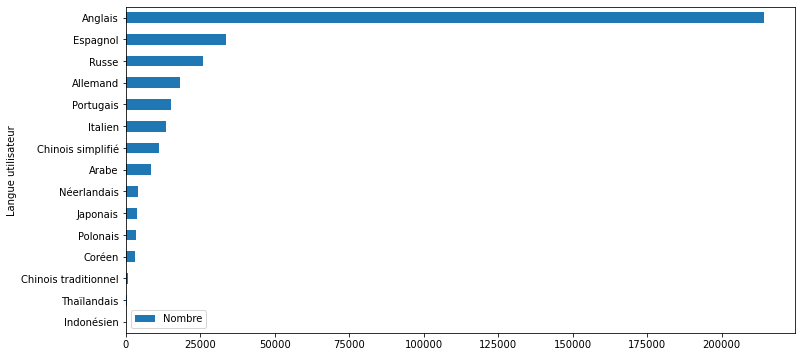

In [10]:
dt_language.plot.barh(figsize = (12,6))
dt_language

**Remarque :**      
On observe que la deuxième langue la plus utilisée est l'anglais, suivi par l'espagnol et le russe.

### Etude sur les langues en fonction du système d'exploitation utilisé :

In [11]:
dt_users = df.groupby(['Langue utilisateur','Version système exploitation']).size()
dt_users.columns = ['Users Langage','System','Number of users per system']
dt_users

Langue utilisateur  Version système exploitation
Allemand            Android                         2491
                    Autre                           4760
                    Mac                             1574
                    Windows                         1142
                    Windows Phone                      3
                                                    ... 
Russe               iOS                             9522
Thaïlandais         Android                           99
                    Autre                            169
                    Windows                            4
                    iOS                              140
Length: 85, dtype: int64

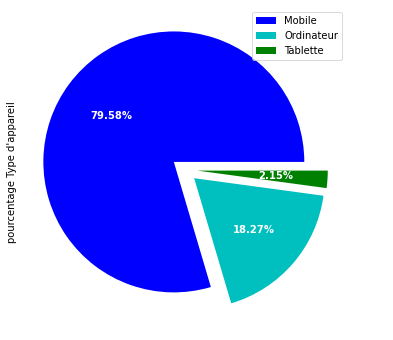

In [12]:
df.groupby('Type d\'appareil').size().plot(kind='pie', explode = (0.1,0.1,0.1),
         autopct='%1.2f%%',colors=['b', 'c','g','r','black','orange','y','m'],
         textprops={'color': 'w', 'weight': 'bold'},label = 'pourcentage Type d\'appareil ',figsize=(12, 6))
plt.legend(framealpha=0.7, frameon=True,loc = 'upper right');

**Analyse :**
- Sur les hotspots on remarque bien que la plus part des utilisateurs se connectent des appareils mobiles (presque 80% des utilisateurs).

### Etude des données des contructeurs et systèmes d'exploitation en fonction des connexions aux hotspots publics à Paris :

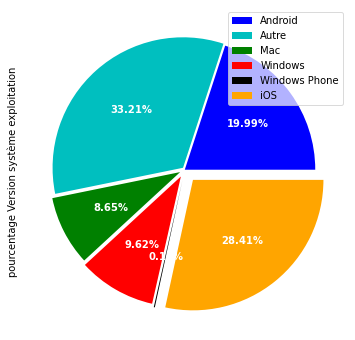

In [13]:
dt = df.groupby('Version système exploitation').size()
dt.plot(kind='pie',explode=[i/50 for i in range(0,len(dt))],
         autopct='%1.2f%%',colors=['b', 'c','g','r','black','orange','y','m'],
         textprops={'color': 'w', 'weight': 'bold'},label = 'pourcentage Version système exploitation ',figsize = (12,6))
plt.legend(framealpha=0.7, frameon=True,loc = 'upper right');

**Analyse :**
- Windows phone est le moins utilisé par les hotspots
- les Iphones (IOS) sont plus utilisés sur les hotspots de paris que les autres androids tel
- Team Apple (8.65% Mac + 28,41 % iOS) gagne contre Android et Windows

In [14]:
dt = pd.DataFrame(df.groupby('Constructeur appareil').size()).reset_index()


In [15]:
# on va utiliser plotly parce que avec matplotlib il parait un peu difficile de mettre les petites percentage d'une façon lisible
dt.columns =['Constructeur appareil','Nombre appareils connectés']


fig = px.pie(dt, values='Nombre appareils connectés', names='Constructeur appareil', title='Pourcentage de nombre d\'appareil connecté par Constructeur')
fig.show()
dt

Constructeur appareil  Nombre appareils connectés
0                 Apple                      539866
1                  Asus                        8146
2                   HTC                        2054
3                HUAWEI                       31226
4                    LG                        3751
5                 Nokia                        7810
6               Samsung                      115728
7                 autre                      748324

**Analyse :**
- 37% des consctructeurs des appareils connectées sur les hotspots de Paris sont des appareils Apple ce qui confirme bien notre calcul sur le chart précédent.
- malgrés le prix sur le marché de Samsung et d'autre constructeurs de téléphonnes mobiles comme HTC,LG,Asus qui offrent des bonnes caractéristiques (caméra, stockage, Ram) avec des prix raisonnables Apple toujours gagne avec ses Iphones dans ce duel.
- à Noter qu'il y a des marques qui ne sont pas connues 51% ces marques peuvent être des contructeurs non reconnus par le systèmes et qui offrent des services à prix compétitif (Xiaomi, Honor, Sony etc..

###  Analyse les sites opérationnels :

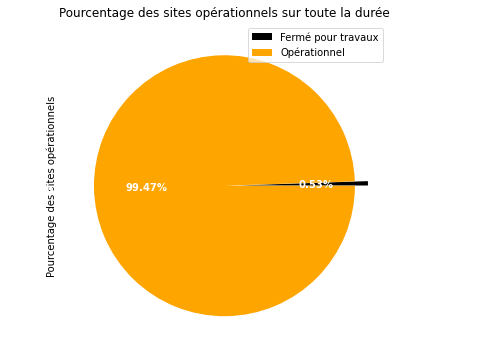

In [16]:
df.groupby('Etat du site').size().plot(kind='pie',explode = (0.1,0),
         autopct='%1.2f%%',colors=['black','orange','y','m'],
         textprops={'color': 'w', 'weight': 'bold'},label = 'Pourcentage des sites opérationnels',
                                       title = 'Pourcentage des sites opérationnels sur toute la durée',
                                       figsize = (12,6))
plt.legend(framealpha=0.7, frameon=True,loc = 'upper right');

99.47% des sites sont opérationnels 

Le graphe ci-dessus ne donne pas une idée précise sur les fonctionnements de site car un site peut fonctionner dans une période et peut ne pas fonctionner dans une autre, du coup la charte juste présente la pourcentage de fonctionalité de toutes les sites pendant toutes les durées

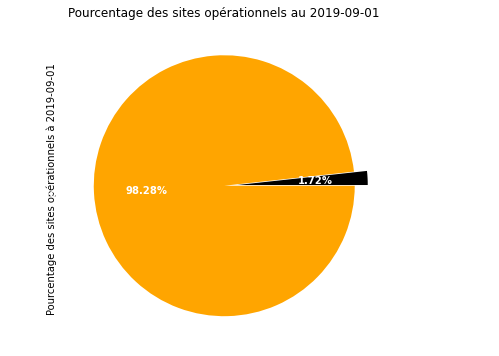

In [17]:
# on va fixer une date et on va trier les site par coordonnée GPS pour avoir une idée exacte sur le fonctionnement de toutes les sites et les comparer sur le même axe de temps
df_site = (df.loc[df['Date début'] == '2019-09-01'].groupby(['Etat du site', 'geo_point_2d']).size() 
   .sort_values(ascending=False) 
   .reset_index(name='count') 
   .drop_duplicates(subset='geo_point_2d')).groupby('Etat du site').size().plot(kind='pie',explode = (0.1,0),
         autopct='%1.2f%%',colors=['black','orange','y','m'],
         textprops={'color': 'w', 'weight': 'bold'},label = 'Pourcentage des sites opérationnels à 2019-09-01  ',title = 'Pourcentage des sites opérationnels au 2019-09-01',
                                                                                figsize = (12,6))


# df_site.drop(df_site.columns[1], axis=1)


Pour la date de 09 Nov 2019 on a 98.28% des site à Paris qui opèrent d'une façon normale et 1.72% non. si on compare avec la pourcentage ci-dessous on trouve bien des valeurs proches.

### Analyse des type d'appareil connecté par arrondissement :
- Dans cette partie on va éliminer les lignes ayant 'autre' comme type de constructeur d'appareil afin de mettre en relief l'importance de présence le constructeur Apple sur des arrondissement spécifique

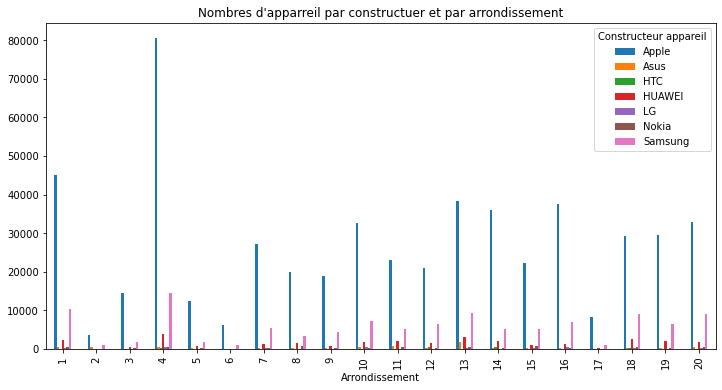

In [18]:
# fig = plt.figure()
dt_Arr = df.loc[df['Constructeur appareil'] != 'autre'].groupby(['Constructeur appareil','Arrondissement']).size()

# dt_Arr.drop(dt_Arr.loc[dt_Arr['Constructeur appareil']=='autre'].index, inplace=True)
dt_Arr.unstack(0).plot.bar(figsize = (12,6), title = 'Nombres d\'apparreil par constructuer et par arrondissement');


**Analyse**:
- On remarque bien Apple est numéro 1 dans toutes les arrondissements comme produit utilisé
- Dans le 1er et le 4 eme arrondissements on remarque la présence de Apple d'une façon  plus importante que dans les autre arrondissements.
- la présence de Apple dans un arrondissement que d'autre n'est pas un signe de richesse (les riches n'utilisent pas l'internet publics), ces 2 arrondissements sont concentrent beaucoup de commerces et lieux de sorties (Chatelet, hotel de ville, le marais,...).
- On retrouve Samsung en deuxième position.

In [19]:
data = df.reset_index()

In [20]:
data_num=data[data.columns[[0,1,2,3,4,8,9,11,12,13]]]

data_num['latitude'] = data_num['geo_point_2d'].apply(lambda x: x.split(',')[0]).astype('float')
data_num['longitude'] = data_num['geo_point_2d'].apply(lambda x: x.split(',')[1]).astype('float')
data_num.drop_duplicates(subset='geo_point_2d')
data_num=data_num.dropna()
data_num

Code Site  Date début Heure début  Temps de session en secondes  \
0          PW0123  2019-09-01    01:57:00                           227   
1          PW0175  2019-09-01    10:41:00                           422   
2          PW0165  2019-09-01    11:21:00                           498   
3        PW0170-1  2019-09-01    11:21:00                           705   
4          PW0176  2019-09-01    12:07:00                           241   
...           ...         ...         ...                           ...   
1456900  PW0122-1  2021-07-13    12:54:00                           262   
1456901    PW0182  2021-07-13    12:53:00                          4042   
1456902    PW0079  2021-07-13    13:02:00                           364   
1456903    PW0242  2021-07-13    13:07:00                           376   
1456904    PW0224  2021-07-13    13:19:00                          2618   

        Code postal  Donnée entrante (MégaOctet)  Donnée sortante (MégaOctet)  \
0             75004                     7.345041                     0.620479   
1             75016                     6.281727                     2.515600   
2             75007                     3.613858                    36.854736   
3             75018                    12.846315                     1.298436   
4             75009                     7.102993                    11.631099   
...             ...                          ...                          ...   
1456900       75004                    11.670561                     1.714846   
1456901       75019                    50.999406                     7.930611   
1456902       75013                     3.067920                     0.631872   
1456903       75019                     2.249522                     0.598598   
1456904       75013                    41.852722                     6.557491   

                        geo_point_2d  Etat du site  Nombre de bornes  \
0        48.8563193139,2.35175507673  Opérationnel               1.0   
1        48.8609372147,2.28934994437  Opérationnel               1.0   
2        48.8569794103,2.29333906348  Opérationnel               1.0   
3        48.8858336546,2.36504782956  Opérationnel               2.0   
4        48.8765956695,2.33179827521  Opérationnel               1.0   
...                              ...           ...               ...   
1456900   48.856389683,2.35238826701  Opérationnel               4.0   
1456901   48.8827940633,2.3827054256  Opérationnel               2.0   
1456902  48.8331703217,2.36627858766  Opérationnel               1.0   
1456903  48.8768070323,2.39380457727  Opérationnel               1.0   
1456904   48.819396456,2.34838164871  Opérationnel               1.0   

          latitude  longitude  
0        48.856319   2.351755  
1        48.860937   2.289350  
2        48.856979   2.293339  
3        48.885834   2.365048  
4        48.876596   2.331798  
...            ...        ...  
1456900  48.856390   2.352388  
1456901  48.882794   2.382705  
1456902  48.833170   2.366279  
1456903  48.876807   2.393805  
1456904  48.819396   2.348382  

[1456905 rows x 12 columns]

###  Visualiser les sites opérationnels et non opérationnels sur la carte:
Dans cette partie je m'inspire du tutoriel fait sur la page de module folium sur les AIRBNB à Paris et je refais le même avec les hotspots à Paris.

In [21]:
data_num1=data[data.columns[[0,1,2,3,4,8,9,11,12,13]]]

data_num1['latitude'] = data_num1['geo_point_2d'].apply(lambda x: x.split(',')[0]).astype('float')
data_num1['longitude'] = data_num1['geo_point_2d'].apply(lambda x: x.split(',')[1]).astype('float')
data_num1.drop('Date début', axis=1, inplace=True)
data_num1.drop('Heure début', axis=1, inplace=True)
data_num1.drop('Code Site', axis=1, inplace=True)
data_num1 = data_num1.drop_duplicates(subset='geo_point_2d')
data_num1=data_num1.dropna()
data_num1

Temps de session en secondes Code postal  Donnée entrante (MégaOctet)  \
0                                227       75004                     7.345041   
1                                422       75016                     6.281727   
2                                498       75007                     3.613858   
3                                705       75018                    12.846315   
4                                241       75009                     7.102993   
...                              ...         ...                          ...   
144167                          1503       75019                    17.927768   
146710                          4199       75006                   907.241836   
147068                          3166       75017                    42.071722   
158895                          1680       75015                     2.447549   
197371                           331       75012                     0.004046   

        Donnée sortante (MégaOctet)                 geo_point_2d  \
0                          0.620479  48.8563193139,2.35175507673   
1                          2.515600  48.8609372147,2.28934994437   
2                         36.854736  48.8569794103,2.29333906348   
3                          1.298436  48.8858336546,2.36504782956   
4                         11.631099  48.8765956695,2.33179827521   
...                             ...                          ...   
144167                     2.248172  48.8919537188,2.37891802857   
146710                    36.448786   48.8432681805,2.3334967424   
147068                     1.944154  48.8957682345,2.31183047537   
158895                     0.378209  48.8455716175,2.29151247283   
197371                     0.008292  48.8622112385,2.38030876951   

        Etat du site  Nombre de bornes   latitude  longitude  
0       Opérationnel               1.0  48.856319   2.351755  
1       Opérationnel               1.0  48.860937   2.289350  
2       Opérationnel               1.0  48.856979   2.293339  
3       Opérationnel               2.0  48.885834   2.365048  
4       Opérationnel               1.0  48.876596   2.331798  
...              ...               ...        ...        ...  
144167  Opérationnel               1.0  48.891954   2.378918  
146710  Opérationnel               3.0  48.843268   2.333497  
147068  Opérationnel               1.0  48.895768   2.311830  
158895  Opérationnel               1.0  48.845572   2.291512  
197371  Opérationnel               1.0  48.862211   2.380309  

[258 rows x 9 columns]

In [22]:
listing_df = data_num1
nbh_geo_df = gpd.read_file('neighbourhoods.geojson', driver='GeoJSON')
nbh_geo_df = nbh_geo_df[['neighbourhood', 'geometry']]

In [23]:
locs_geometry = [Point(xy) for xy in zip(listing_df.latitude,
                                         listing_df.longitude)]
crs = {'init': 'epsg:4326'}
# Coordinate Reference Systems, "epsg:4326" is a common projection of WGS84 Latitude/Longitude
locs_gdf = gpd.GeoDataFrame(listing_df, crs=crs, geometry=locs_geometry)
locs_gdf['Etat du site'].value_counts()

Opérationnel          255
Fermé pour travaux      3
Name: Etat du site, dtype: int64

In [24]:

locs_map = folium.Map(location=[48.856614, 2.3522219],
                      zoom_start=13, tiles='cartodbpositron')

feature_ea = folium.FeatureGroup(name='Opérationnel')
feature_pr = folium.FeatureGroup(name='Fermé pour travaux')
style_function = lambda x: {
    'fillColor': nbh_count_colormap(x['properties']['nb']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

for i, v in locs_gdf.iterrows():

    
    if v['Etat du site'] == 'Opérationnel':
        folium.CircleMarker(location=[v['latitude'], v['longitude']],
                            radius=1.5,
                            color='#008000',
                            fill_color='#008000',
                            fill=True).add_to(feature_ea)
    elif v['Etat du site'] == 'Fermé pour travaux':
        folium.CircleMarker(location=[v['latitude'], v['longitude']],
                            radius=3,
                            color='#BB0B0B',
                            fill_color='#BB0B0B',
                            fill=True).add_to(feature_pr)




feature_ea.add_to(locs_map)
feature_pr.add_to(locs_map)

folium.LayerControl(collapsed=False).add_to(locs_map);
locs_map

In [25]:
cluster_map = folium.Map(location=[48.856614, 2.3522219],
                         zoom_start=13, tiles='cartodbpositron')

marker_cluster = plugins.MarkerCluster().add_to(cluster_map)
for i, v in locs_gdf.iterrows():

    
    if v['Etat du site'] == 'Opérationnel':
        folium.CircleMarker(location=[v['latitude'], v['longitude']],
                            radius=3,
                            color='#FFBA00',
                            fill_color='#FFBA00',
                            fill=True).add_to(marker_cluster)
    elif v['Etat du site'] == 'Fermé pour travaux':
        folium.CircleMarker(location=[v['latitude'], v['longitude']],
                            radius=3,
                            color='#087FBF',
                            fill_color='#087FBF',
                            fill=True).add_to(marker_cluster)

cluster_map

**Analyse** : on remarque bien que les hotspots sont bien répartie à Paris, quasimment les zones de fortes usages sont bien couvertes par des bornes de Wifi public.

### Etude et aggregation en fonction de temps de connexion :

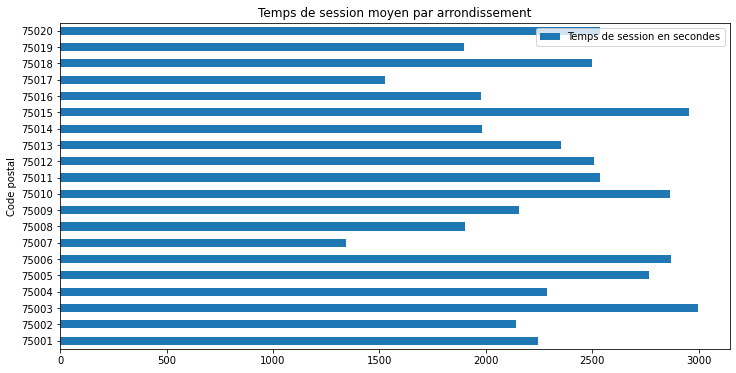

In [26]:
dt_users = df.groupby('Code postal').agg({'Temps de session en secondes':'mean'})
dt_users.plot.barh(figsize = (12,6),title = 'Temps de session moyen par arrondissement');


###  Nombre de bornes totale par arrondissement( en éliminant les doubles des codes sites):

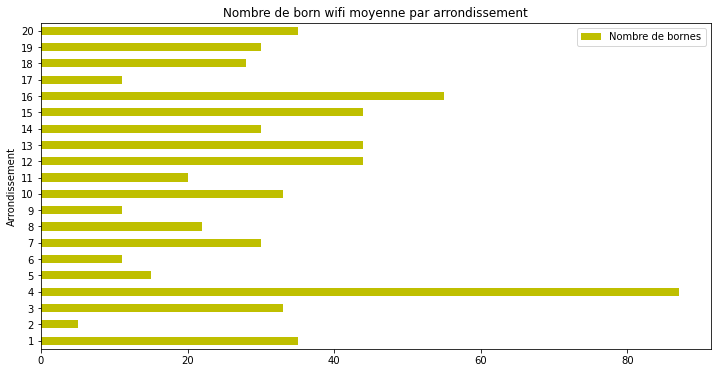

In [27]:
(df.groupby(['Arrondissement','Nombre de bornes','Code Site']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='Code Site')).groupby('Arrondissement').agg({'Nombre de bornes':'sum'}).plot.barh(title = 'Nombre de born wifi moyenne par arrondissement',figsize =(12,6),color = 'y');

**Analyse** :
- On remarque que le nombre total des bornes en 4ème arrondissement est très important. Ce résultat est à corréler avec le nombre d'appareils connectés dans le 4ème arrondissement, comme déja vu dans la figure Nombres d'apparreil par constructeur et par arrondissement (voir bar ci-dessous)

### Etude série temporelle sur l'impact de COV-19 sur l'usage des hotspots Wifi public  :

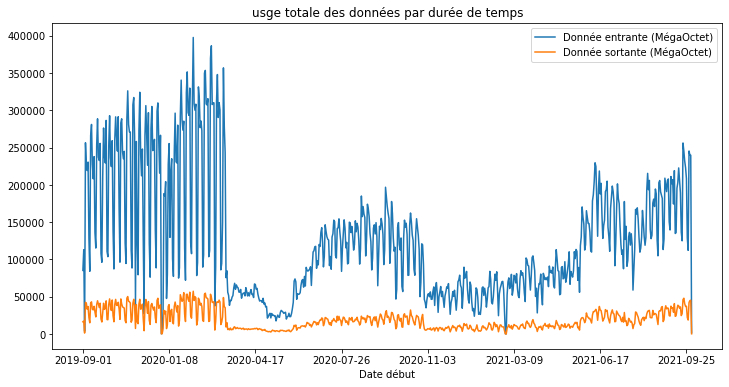

In [28]:
g=data_num.groupby('Date début').agg({'Donnée entrante (MégaOctet)':'sum', 'Donnée sortante (MégaOctet)':'sum'}).plot(legend=True,figsize = (12,6),title ='usge totale des données par durée de temps')

In [29]:
data_num.groupby('Date début').agg({'Donnée entrante (MégaOctet)':'sum', 'Donnée sortante (MégaOctet)':'sum'}).sort_values('Donnée entrante (MégaOctet)'
                                                                                                                           ,ascending=False)

Donnée entrante (MégaOctet)  Donnée sortante (MégaOctet)
Date début                                                          
2020-02-05                397931.745794                 57356.670499
2020-02-26                386740.091396                 49153.962009
2020-02-25                370092.526286                 53313.446475
2020-03-11                357122.123747                 48881.014297
2020-02-19                353732.062474                 54747.275637
...                                 ...                          ...
2021-10-01                  1669.266925                   224.345039
2019-12-31                   610.979014                   580.308173
2021-02-01                   502.157687                    66.840748
2019-12-01                   400.863798                    55.655316
2021-02-28                   193.614414                     9.495486

[707 rows x 2 columns]

**Analyse :**
- On remarque que la quantité des données sur 2 ans entre septembre 2019 et septembre 2021 à Paris peut arriver à un pic de 400 go/jours sur toutes les bornes de tout Paris en une seule journée. 
- les 3 périodes de confinement en France sont : 
    * du 17 mars au 10 mai 2020 (non inclus, soit 1 mois et 25 jours)
    * du 30 octobre au 15 décembre 2020 (non inclus, soit 1 mois et 14 jours)
    * du 3 avril au 3 mai 2021 (non inclus, soit 28 jours).
- On remarque les faibles usages des données sur les hotspots publics dans la période de premier confinemet (10 fois moins)
- On remarque également sur les deux autres période de confinement que les usages des hots spots publics sont faibles, impactées soit par le confinement soit par les couvres feu

**Conclusion :**

- Nos données nous montrent bien l'impact de l'épédémie sur l'usage des bornes internet en publique.
- On peut diviser notre dataset en deux parties, une partie avant Covid et une partie aprés COVID. même après le retour de confinement l'usgage de ces bornes sont réduites, est ce qu'on peut dire que le COVID a un impact social sur les individus à Paris? ou avec le COVID le secteur de tourisme à Paris a été réduit?

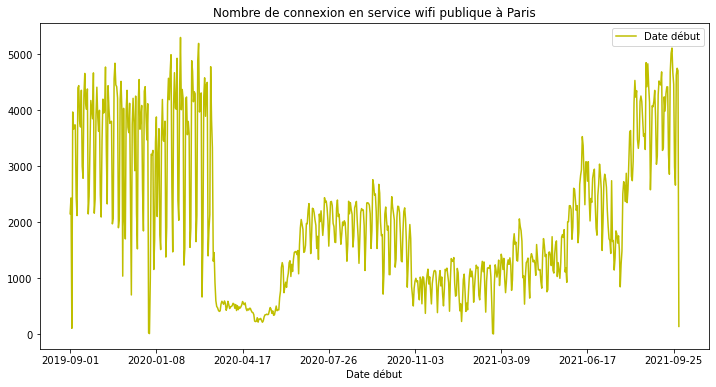

In [30]:
g_user_number=data_num.groupby('Date début').agg({'Date début':'count'}).plot(legend=True,figsize = (12,6),title ='Nombre de connexion en service wifi publique à Paris',color = 'y')

Le nombre des personnes connectées confirme bien les deux périodes avant et après COVID, cette courbe evoluera encore aprés la 5 eme vague de COVID19 en cas de 4ème confinement

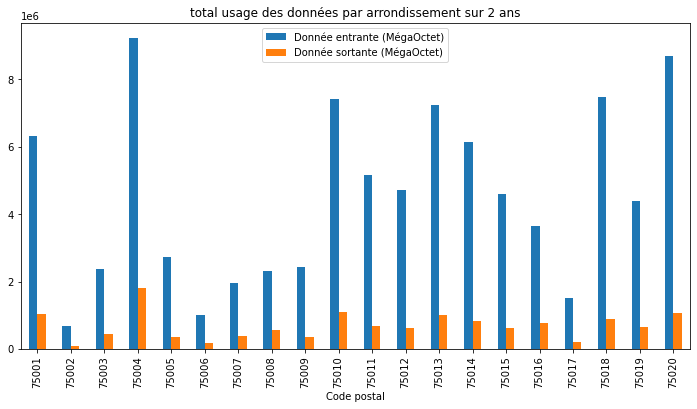

In [31]:
g=data_num.groupby('Code postal').agg({'Donnée entrante (MégaOctet)':'sum', 'Donnée sortante (MégaOctet)':'sum'}).plot(legend=True,kind='bar',title='total usage des données par arrondissement sur 2 ans',figsize = (12,6))

## IV. Partie Machine LEARNING

Nombre des users par période d'usage:

In [32]:
# nombre d'usage par jour sur 2 ans à peu pré (707 jours)
data_usages = df.groupby('Date début').size().reset_index()
data_usages.columns=['Date','Nombre de connexion']

**On utilise LinearRegression modéle pour chercher quelques  liaisons entre les données :**

In [33]:
d= data_num.groupby('Date début').agg({'Donnée entrante (MégaOctet)':'mean', 'Temps de session en secondes':'mean'})
X = d[['Temps de session en secondes']].values
y = d['Donnée entrante (MégaOctet)']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.33)
lr = LinearRegression().fit(X_train,y_train)
a = lr.coef_
b = lr.intercept_
print(f'le score de ce modéle est {round(lr.score(X_test,y_test),2)} avec coeif de regression = {a} et intercept = {b}')

le score de ce modéle est 0.74 avec coeif de regression = [0.03363787] et intercept = -12.923602310831


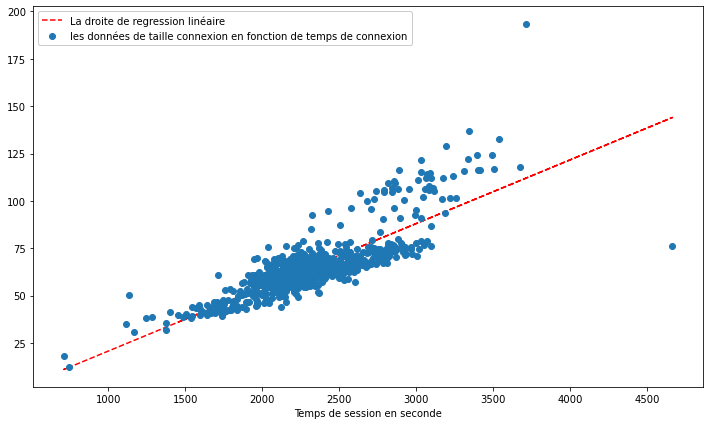

In [34]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(X, a * X +b,'r--', label = 'La droite de regression linéaire ')
ax.plot(X,y,'o', label = 'les données de taille connexion en fonction de temps de connexion')
ax.set_xlabel('Temps de session en seconde')
ax.legend(framealpha=1, frameon=True);

Prédiction des données utilisées si on se connecte pendant 2 heures moyenné par jour

In [35]:
print(f'Pour 2 heures de connexion l\'utilisateur est prédit à consommer environ {round(lr.predict([[7200]])[0],2)} Mo moyennement par jour ') 

Pour 2 heures de connexion l'utilisateur est prédit à consommer environ 229.27 Mo moyennement par jour 


**Clustering** : On cherche dans cette partie à suivre le comportement des utilisateurs pour savoir comment sont utilisés les hotspots de WIFI publics à Paris.

Tentatives: On a essayé plusieurs approches: (supprimées déja mais je veux bien décrire un peu le projet)
  - De faire de clusering avec séries temporelles autrement dit comprtement de l'utilsateur en fonction de temps de début de connexion sur les hotspot. Faut de temps et de savoir faire sur le sujet (de manipuler des cluster avec des données series temporelles) on a abondonnée cette piste.
  - J'ai essayé de faire clustering avec K-means les langues d'utilisateurs en fonction d'arrondissement et je suis fini âr avoir 15 centre de cluster (tout à fait normal) on a abondonnée cette piste sur tout avec le challenge de transformer les variables en numérique et les scaler.
  

In [36]:
X_num = data_num[['Temps de session en secondes','Donnée entrante (MégaOctet)','Donnée sortante (MégaOctet)']]


**Clustering: Comprtement utilisateur vis à vis durée d'usage des données et quantité d'usage** 

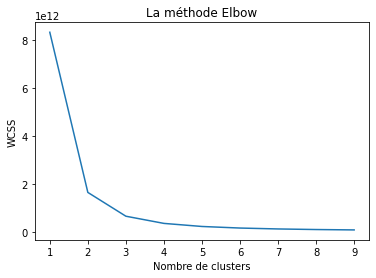

In [37]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X_num)
    wcss.append(kmeans.inertia_)
wcss
plt.plot(range(1, 10), wcss)
plt.title('La méthode Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
kmeans1 = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
kmeans1.fit(X_num)
X_num

Temps de session en secondes  Donnée entrante (MégaOctet)  \
0                                 227                     7.345041   
1                                 422                     6.281727   
2                                 498                     3.613858   
3                                 705                    12.846315   
4                                 241                     7.102993   
...                               ...                          ...   
1456900                           262                    11.670561   
1456901                          4042                    50.999406   
1456902                           364                     3.067920   
1456903                           376                     2.249522   
1456904                          2618                    41.852722   

         Donnée sortante (MégaOctet)  
0                           0.620479  
1                           2.515600  
2                          36.854736  
3                           1.298436  
4                          11.631099  
...                              ...  
1456900                     1.714846  
1456901                     7.930611  
1456902                     0.631872  
1456903                     0.598598  
1456904                     6.557491  

[1456905 rows x 3 columns]

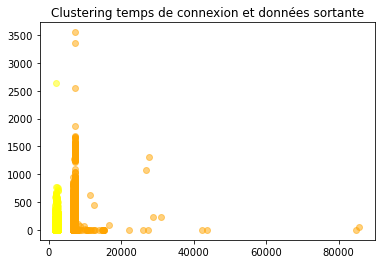

In [39]:
cluster1= X_num[kmeans.labels_ == 1]
cluster0= X_num[kmeans.labels_ == 0]
plt.scatter(cluster1["Temps de session en secondes"], cluster1['Donnée sortante (MégaOctet)'], c='orange',alpha = 0.5)
plt.scatter(cluster0["Temps de session en secondes"], cluster0['Donnée sortante (MégaOctet)'], c='yellow',alpha = 0.5)
plt.title('Clustering temps de connexion et données sortante');

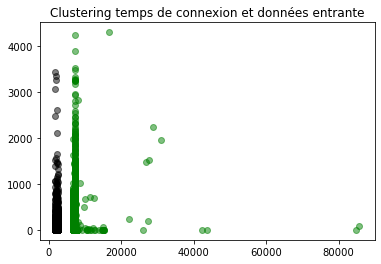

In [40]:
cluster1= X_num[kmeans.labels_ == 1]
cluster0= X_num[kmeans.labels_ == 0]
plt.scatter(cluster1["Temps de session en secondes"], cluster1['Donnée entrante (MégaOctet)'], c='green',alpha = 0.5)
plt.scatter(cluster0["Temps de session en secondes"], cluster0['Donnée entrante (MégaOctet)'], c='black',alpha = 0.5)
plt.title('Clustering temps de connexion et données entrante');

**Analyse :** il ya deux comprtements d'usage de l'internet public, il ya ceux qui restent peu de temps et logiquement ils consomment un peu de données, comme ceux qui utilise des applications de citymapper ou juste pour lire les mails. Le deuxième comportement est de rester trop de temps connecté et de consommer beaucoup des données. La courbe montre qu'il n'y a pas de troisième comportement à part les 2 cités précedemment.

# Conclusion : 

**Partie analyse Data :** 


Les données utilisées sont très riches et nous permettent de savoir plusieurs informations : 
   - Les hotspots à Paris sont utilisés tout le temps et par plusieurs personnes malgrés les soucis de sécurités numériques.
   - Selon les analyses : Apple est le produit numéro 1 utilisé sur les hotspots de wifi publique à Paris
   - Le COVID-19 a son empreinte sur le taux d'usage des hotspots de wifi publique à Paris (voir analyse pour plus en détail)
   - Selon la courbe de répartition des hotspots à Paris, On voit bien que les zones de forte concentration publiques sont 
     bien couvertes par des hotspots de Wifi publique d'ou pas besoin d'installer des nouvelles.
   - Les données sont anonymes, on ne connait pas les IP ni les gens derriéres qui se connectent par contre selon ces données        on peut connaître leurs temps de connexion, leur présence exact, leurs produits nécessaire et tous ça leur rendre un cible      pour autre usage que savoir combient de bornes de Wifi publique à installer à Paris 
   
   
**Partie Technique :**

Le data est très riche et on peut l'exploiter encore et aller plus loin, faute de temps on n'a pas pu aller au dela de ça.
il reste quelques idées à faire et quelques données à exploiter.

Dans ce projet on a l'opportunité d'apprendre :
   - à gérer une grosse fichier de données environ 2 millions de lignes avant nettoyage
   - à découvrir des nouvelles module et package de Anaconda (Plotly, Geopandas, folium...)
   - à représenter les données de plusieurs façon
   - à gérer plusieurs erreur de bug et de programmation
   - à ateindre la limite de memoire dans certain calcul non simplifié
